In [1]:
import os, sys
import h5py
import numpy as np
import pandas as pd
import scipy
import math as m
import cmath
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint
plt.switch_backend('TkAgg')


PROJECT_CWD = r"/workspace/"
sys.path.append(PROJECT_CWD)

from my_packages.neural_network.data_generators.magnetic_array_generator import RandomMagneticDipoleGenerator
from my_packages.neural_network.data_generators.iterator import DataIterator

# torch import 
import torch
from torch.utils.data import TensorDataset, DataLoader

print("cuda available: ", torch.cuda.is_available())
print("number of GPUs: ",torch.cuda.device_count())
print("I am currently using device number: ", torch.cuda.current_device())
print("the device object is: ", torch.cuda.device(0))
print("the device name is: ", torch.cuda.get_device_name(0))


# set all the seeds
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

cuda available:  True
number of GPUs:  1
I am currently using device number:  0
the device object is:  <torch.cuda.device object at 0x7f89d3172170>
the device name is:  NVIDIA T600 Laptop GPU


In [2]:
# data parameters
resolution=(7,7)
field_res = (21,21)
xbounds = [-0.01, 0.01]
ybounds = [-0.01, 0.01]
dipole_height = 1e-3
substrate_thickness = 1.4e-2
substrate_epsilon_r = 4.4
dynamic_range = 10
probe_height = 0.3e-2
dipole_density = 0.2


rmg = RandomMagneticDipoleGenerator(
    resolution=resolution,
    xbounds=xbounds,
    ybounds=ybounds,
    dipole_height=dipole_height,
    substrate_thickness=substrate_thickness,
    substrate_epsilon_r=substrate_epsilon_r,
    dynamic_range=dynamic_range,
    probe_height=probe_height,
    field_res=field_res,
    dipole_density=dipole_density
    )

data_iterator = DataIterator(rmg, normalize=True)

N = 100000
N_test = 1000


# # create the training data
# inputs, target = data_iterator.generate_N_data_samples(N)

# # create the test data
# inputs_test, target_test = data_iterator.generate_N_data_samples(N_test)

# # create the training and test datasets
# train_and_valid_dataset = TensorDataset(torch.from_numpy(inputs).float(), torch.from_numpy(target).float())
# print("train_dataset size: ", len(train_and_valid_dataset))
# test_dataset = TensorDataset(torch.from_numpy(inputs_test).float(), torch.from_numpy(target_test).float())

In [3]:
# save the datasets
save_dir = os.path.join(PROJECT_CWD, "NN_data", "simple_magnetic")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
fullpath = os.path.join(save_dir, "train_and_valid_dataset.pt")
fullpath = os.path.join(save_dir, "test_dataset.pt")

# torch.save(train_and_valid_dataset, fullpath)
# torch.save(test_dataset, fullpath)


In [5]:
# load the data from the datasets
train_and_valid_dataset = torch.load(os.path.join(save_dir, "train_and_valid_dataset.pt"))
test_dataset = torch.load(os.path.join(save_dir, "test_dataset.pt"))

# test
print("train_and_valid_dataset size: ", len(train_and_valid_dataset))
print("test_dataset size: ", len(test_dataset))

train_and_valid_dataset size:  100000
test_dataset size:  1000


In [6]:
batch_size = 64

# split into training and validation sets
train_size = int(0.8 * len(train_and_valid_dataset))
val_size = len(train_and_valid_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_and_valid_dataset, [train_size, val_size])

print("train_dataset size: ", len(train_dataset))
print("val_dataset size: ", len(val_dataset))

# create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True ,num_workers = 4,  pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

train_dataset size:  80000
val_dataset size:  20000


In [7]:
from torch import nn
import torch.nn.functional as F

class CNN_Base(nn.Module):
    def __init__(self, loss_fn=F.mse_loss, *args, **kwargs):
        super(CNN_Base, self).__init__()
        self.loss_fn = loss_fn


    def training_step(self, batch):
        inputs, targets = batch
        out = self(inputs)
        loss = self.loss_fn(out, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        out = self(inputs)
        loss = self.loss_fn(out, targets)
        accuracy = self._accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_acc': accuracy}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, 
            result['train_loss'],  
            result['val_loss'], 
            result['val_acc']))
    def evaluate(self, val_loader):
        self.eval() # set to evaluation mode
        outputs = [self.validation_step(batch) for batch in val_loader]
        return self.validation_epoch_end(outputs)
    
    @staticmethod
    def _accuracy(out, targets, thresh=0.5):
        with torch.no_grad():
            # Convert output probabilities to binary values (0 or 1)
            out_binary = (out > thresh).float()

            # Calculate true positives, false positives and false negatives
            true_positives = (out_binary * targets).sum().item()
            false_positives = (out_binary * (1 - targets)).sum().item()
            false_negatives = ((1 - out_binary) * targets).sum().item()

            # Calculate precision and recall
            precision = true_positives / (true_positives + false_positives + 1e-8)
            recall = true_positives / (true_positives + false_negatives + 1e-8)

            # Calculate F1 score
            f1_score = 2 * (precision * recall) / (precision + recall + 1e-8)
            return torch.tensor(f1_score)

class CNN(CNN_Base):
    def __init__(self, out_shape, conv_size1=32, conv_size2=64, linear_size1 = 128, loss_fn=F.mse_loss):
        out_size = np.prod(out_shape)
        super(CNN, self).__init__(loss_fn=loss_fn)
        self.network = nn.Sequential(
            nn.Conv2d(2, conv_size1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(conv_size1, conv_size2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: conv_size2 x 10 x 10

            nn.Flatten(),
            nn.Linear(conv_size2 * 10 * 10, linear_size1),
            nn.ReLU(),
            nn.Linear(linear_size1, out_size),
            nn.Unflatten(1, out_shape)

        )
    
    def forward(self, xb):
        return self.network(xb)

    
    
    
        
    

In [8]:
from torchsummary import summary

input_shape =   (2, 21, 21)
output_shape =  (2, 7, 7)
out_size = 7*7*2

model = CNN(output_shape)

summary(model, input_shape, batch_size=-1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 21, 21]             608
              ReLU-2           [-1, 32, 21, 21]               0
            Conv2d-3           [-1, 64, 21, 21]          18,496
              ReLU-4           [-1, 64, 21, 21]               0
         MaxPool2d-5           [-1, 64, 10, 10]               0
           Flatten-6                 [-1, 6400]               0
            Linear-7                  [-1, 128]         819,328
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 98]          12,642
        Unflatten-10              [-1, 2, 7, 7]               0
Total params: 851,074
Trainable params: 851,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.75
Params size (MB): 3.25
Estimated T

In [9]:
# consider the GPU7
from my_packages.neural_network.gpu_aux import get_default_device, to_device, DeviceDataLoader

device = get_default_device()
print("device: ", device)

# move the dataloaders to the GPU
train_dl = DeviceDataLoader(train_dataloader, device)
val_dl = DeviceDataLoader(val_dataloader, device)
test_dl = DeviceDataLoader(test_dataloader, device)


device:  cuda


In [10]:
import wandb

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            # Log params to wandb
            for name, param in model.named_parameters():
                if param.requires_grad:
                    wandb.log({f"{name}_grad_norm": param.grad.norm(),
                            f"{name}_grad_mean": param.grad.mean(),
                            f"{name}_grad_std": param.grad.std(),
                            f"{name}_grad_max": param.grad.max(),
                            f"{name}_grad_min": param.grad.min()}, step=epoch)
                    wandb.log({f"{name}_param_norm": param.norm(),
                            f"{name}_param_mean": param.mean(),
                            f"{name}_param_std": param.std(),
                            f"{name}_param_max": param.max(),
                            f"{name}_param_min": param.min()}, step=epoch)
            optimizer.step()
            optimizer.zero_grad()
            

        # Validation phase
        result = model.evaluate(val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        
        # Log accuracy and loss to wandb
        wandb.log({"val_acc": result['val_acc'], "val_loss": result['val_loss']}, step=epoch)
        
        if (epoch) % 10 == 0:
            model.epoch_end(epoch, result)
        history.append(result)
    return history

In [11]:
output_shape = (2, 7, 7)
conv_layer1_size = 32
conv_layer2_size = 64
linear_layer1_size = 128
loss_fn = nn.BCEWithLogitsLoss()


model = CNN(
    output_shape, 
    conv_size1=conv_layer1_size, 
    conv_size2=conv_layer2_size, 
    linear_size1=linear_layer1_size,
    loss_fn=loss_fn)
model = to_device(model, device)

model.evaluate(val_dl)

{'val_loss': 0.6933481693267822, 'val_acc': 0.0}

In [12]:

# create a dataset
loss_fn = nn.BCEWithLogitsLoss()
opt_func = torch.optim.Adam
learning_rate = 1e-3
n_iterations = 15

# model dir
model_dir = os.path.join(PROJECT_CWD, "models", "simple_magnetic")
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# 2a6ac6cf8c981bd8a56480328e6affc93f086c07

config = dict(
    epochs=n_iterations,
    learning_rate=learning_rate,
    conv_layer1_size=conv_layer1_size,
    conv_layer2_size=conv_layer2_size,
    linear_layer1_size=linear_layer1_size,
    loss_fn=loss_fn.__class__.__name__,
    opt_func=opt_func.__name__,
    dataset_size=N,
    test_dataset_size=N_test,
    batch_size=batch_size)

# increase timeout to 300s
os.environ["WANDB__SERVICE_WAIT"] = "300"

wrun = wandb.init(project="magnetic_dipole_inversion", entity="tm95mon", name="CNN2", config=config)
wandb.watch(model, log="all", log_freq=50) 

# save model 
model_artifact = wandb.Artifact('CNN_simple_magnetic', type='model', description='simple 21x21 -> 7x7 mangetic model only', metadata=dict(config))

history = fit(n_iterations, learning_rate, model, train_dl, val_dl, opt_func)
# temp save of the model
torch.save(model.state_dict(), os.path.join(model_dir, "temp.pt"))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tm95mon. Use `wandb login --relogin` to force relogin


Epoch [0], train_loss: 0.1245, val_loss: 0.0705, val_acc: 0.8745
Epoch [10], train_loss: 0.0264, val_loss: 0.0346, val_acc: 0.9505


wandb: ERROR Control-C detected -- Run data was not synced


Test Loss: 162.2520


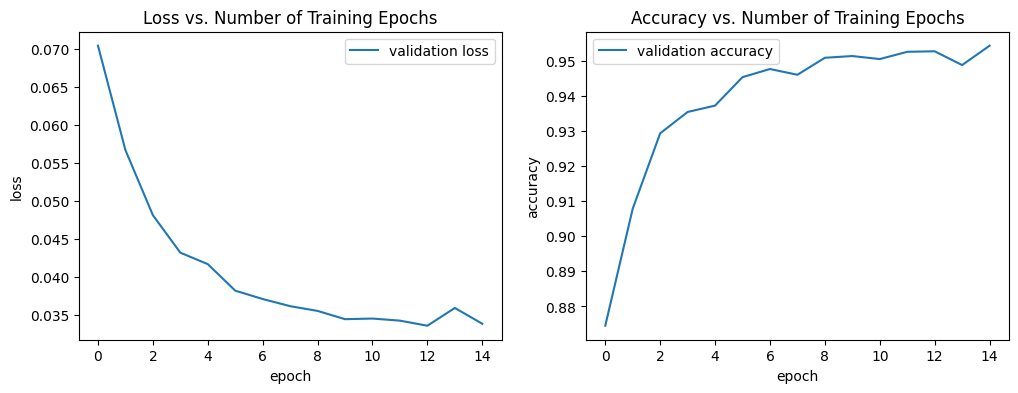

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

h = [x['val_loss'] for x in history]
acc = [x['val_acc'] for x in history]

to_device(model, 'cpu')

# Evaluate the model on the test set
with torch.no_grad():
    test_loss = 0.0
    for test_xb, test_yb in test_dataloader:
        model.eval()
        test_pred = model(test_xb)
        test_loss += loss_fn(test_pred, test_yb).item()
    
    test_loss /= len(test_dataloader)
    print('Test Loss: {:.4f}'.format(test_loss))

# Plot loss and validation loss
fig, (ax, ax1) = plt.subplots(1,2, figsize=(12,4))
ax.plot(h, label='validation loss')

# ax.axhline(y=test_loss, color='r', linestyle='--', label='test loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss vs. Number of Training Epochs')
ax.legend()

ax1.plot(acc, label='validation accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy vs. Number of Training Epochs')
ax1.legend()

plt.show()

In [16]:
for test_xb, test_yb in test_dataloader:
    print(test_xb.shape)
    break

torch.Size([64, 2, 21, 21])


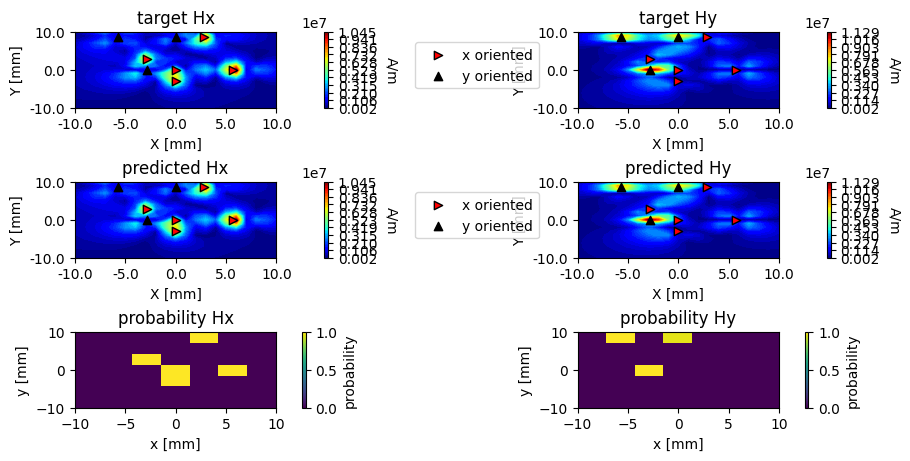

In [21]:
%matplotlib inline
random_H, target = rmg.generate_labeled_data()
def predict(H, threshold=0.5, output_shape =None, renormalize_to_01=False):
    # normalize H
    min_value = np.min(H)
    max_value = np.max(H)
    H = (H - min_value) / (max_value - min_value)

    H = np.expand_dims(H, axis=0)
    H = torch.from_numpy(H).float()
    with torch.no_grad():
        model.eval()
        to_device(model, "cpu")
        pred = model(H)
    pred = pred.numpy().squeeze()
    if output_shape is not None:
        pred = pred.reshape(output_shape)
    # transform to probabilities
    # clip to zero minimum
    if renormalize_to_01:
        max_value = np.max(pred)
        min_value = np.min(pred)
        prob_pred = (pred - min_value) / (max_value - min_value)
    else:
        prob_pred = pred

    binarized_pred = np.zeros_like(pred)
    binarized_pred[prob_pred > threshold] = 1
    pred = binarized_pred
    return pred, prob_pred

certainty = 0.5
prediction, pred_probability = predict(random_H, output_shape=(2,7,7), threshold=certainty)

fig, ax = plt.subplots(3,2, figsize=(9,4.5), constrained_layout=True)

# ax[1,0].pcolor(prediction[0])
rmg.plot_labeled_data(random_H, target, ax=(ax[0,0], ax[0,1]))
ax[0,0].set_title("target Hx")
ax[0,1].set_title("target Hy")
rmg.plot_labeled_data(random_H, prediction, ax=(ax[1,0], ax[1,1]))
ax[1,0].set_title("predicted Hx")
ax[1,1].set_title("predicted Hy")

x_grid, y_grid, _ = rmg.generate_r0_grid()[..., 0]
q1 = ax[2,0].pcolor(x_grid*1e3, y_grid*1e3, pred_probability[0], vmin=0, vmax=1)
q2 = ax[2,1].pcolor(x_grid*1e3, y_grid*1e3, pred_probability[1], vmin=0, vmax=1)
ax[2,0].set_title("probability Hx")
ax[2,1].set_title("probability Hy")
ax[2,0].set_xlabel("x [mm]")
ax[2,1].set_xlabel("x [mm]")
ax[2,0].set_ylabel("y [mm]")
ax[2,1].set_ylabel("y [mm]")
cbar = fig.colorbar(q1, ax=ax[2,0], ticks=[0, 0.5, 1], label="probability")
cbar = fig.colorbar(q2, ax=ax[2,1], ticks=[0, 0.5, 1], label="probability")

In [ ]:
# save the model 
modelname = "CNN_simple_magnetic_v1"

torch.save(model.state_dict(), os.path.join(model_dir, modelname + ".pt"))


# save the model 
model_artifact.add_file(os.path.join(model_dir, "temp.pt"))
wandb.log_artifact(model_artifact)


In [ ]:
wandb.finish();

In [36]:
# increase waiting time to 300s
os.environ["WANDB__SERVICE_WAIT"] = "300"
wandb.finish();